In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt

aac1
0
{0: 6082, 1: 266, 2: 2189, 4: 12}
0
{0: 114, 1: 1, 2: 1}
0
{0: 333}
0
{}
0
{2: 3}
0
{1: 21, 2: 6389, 4: 11}
path 0: 0.4233562443262871
path 1: 0.018674620671767606
path 2: 0.5564777590455194
path 4: 0.0014913759564258852


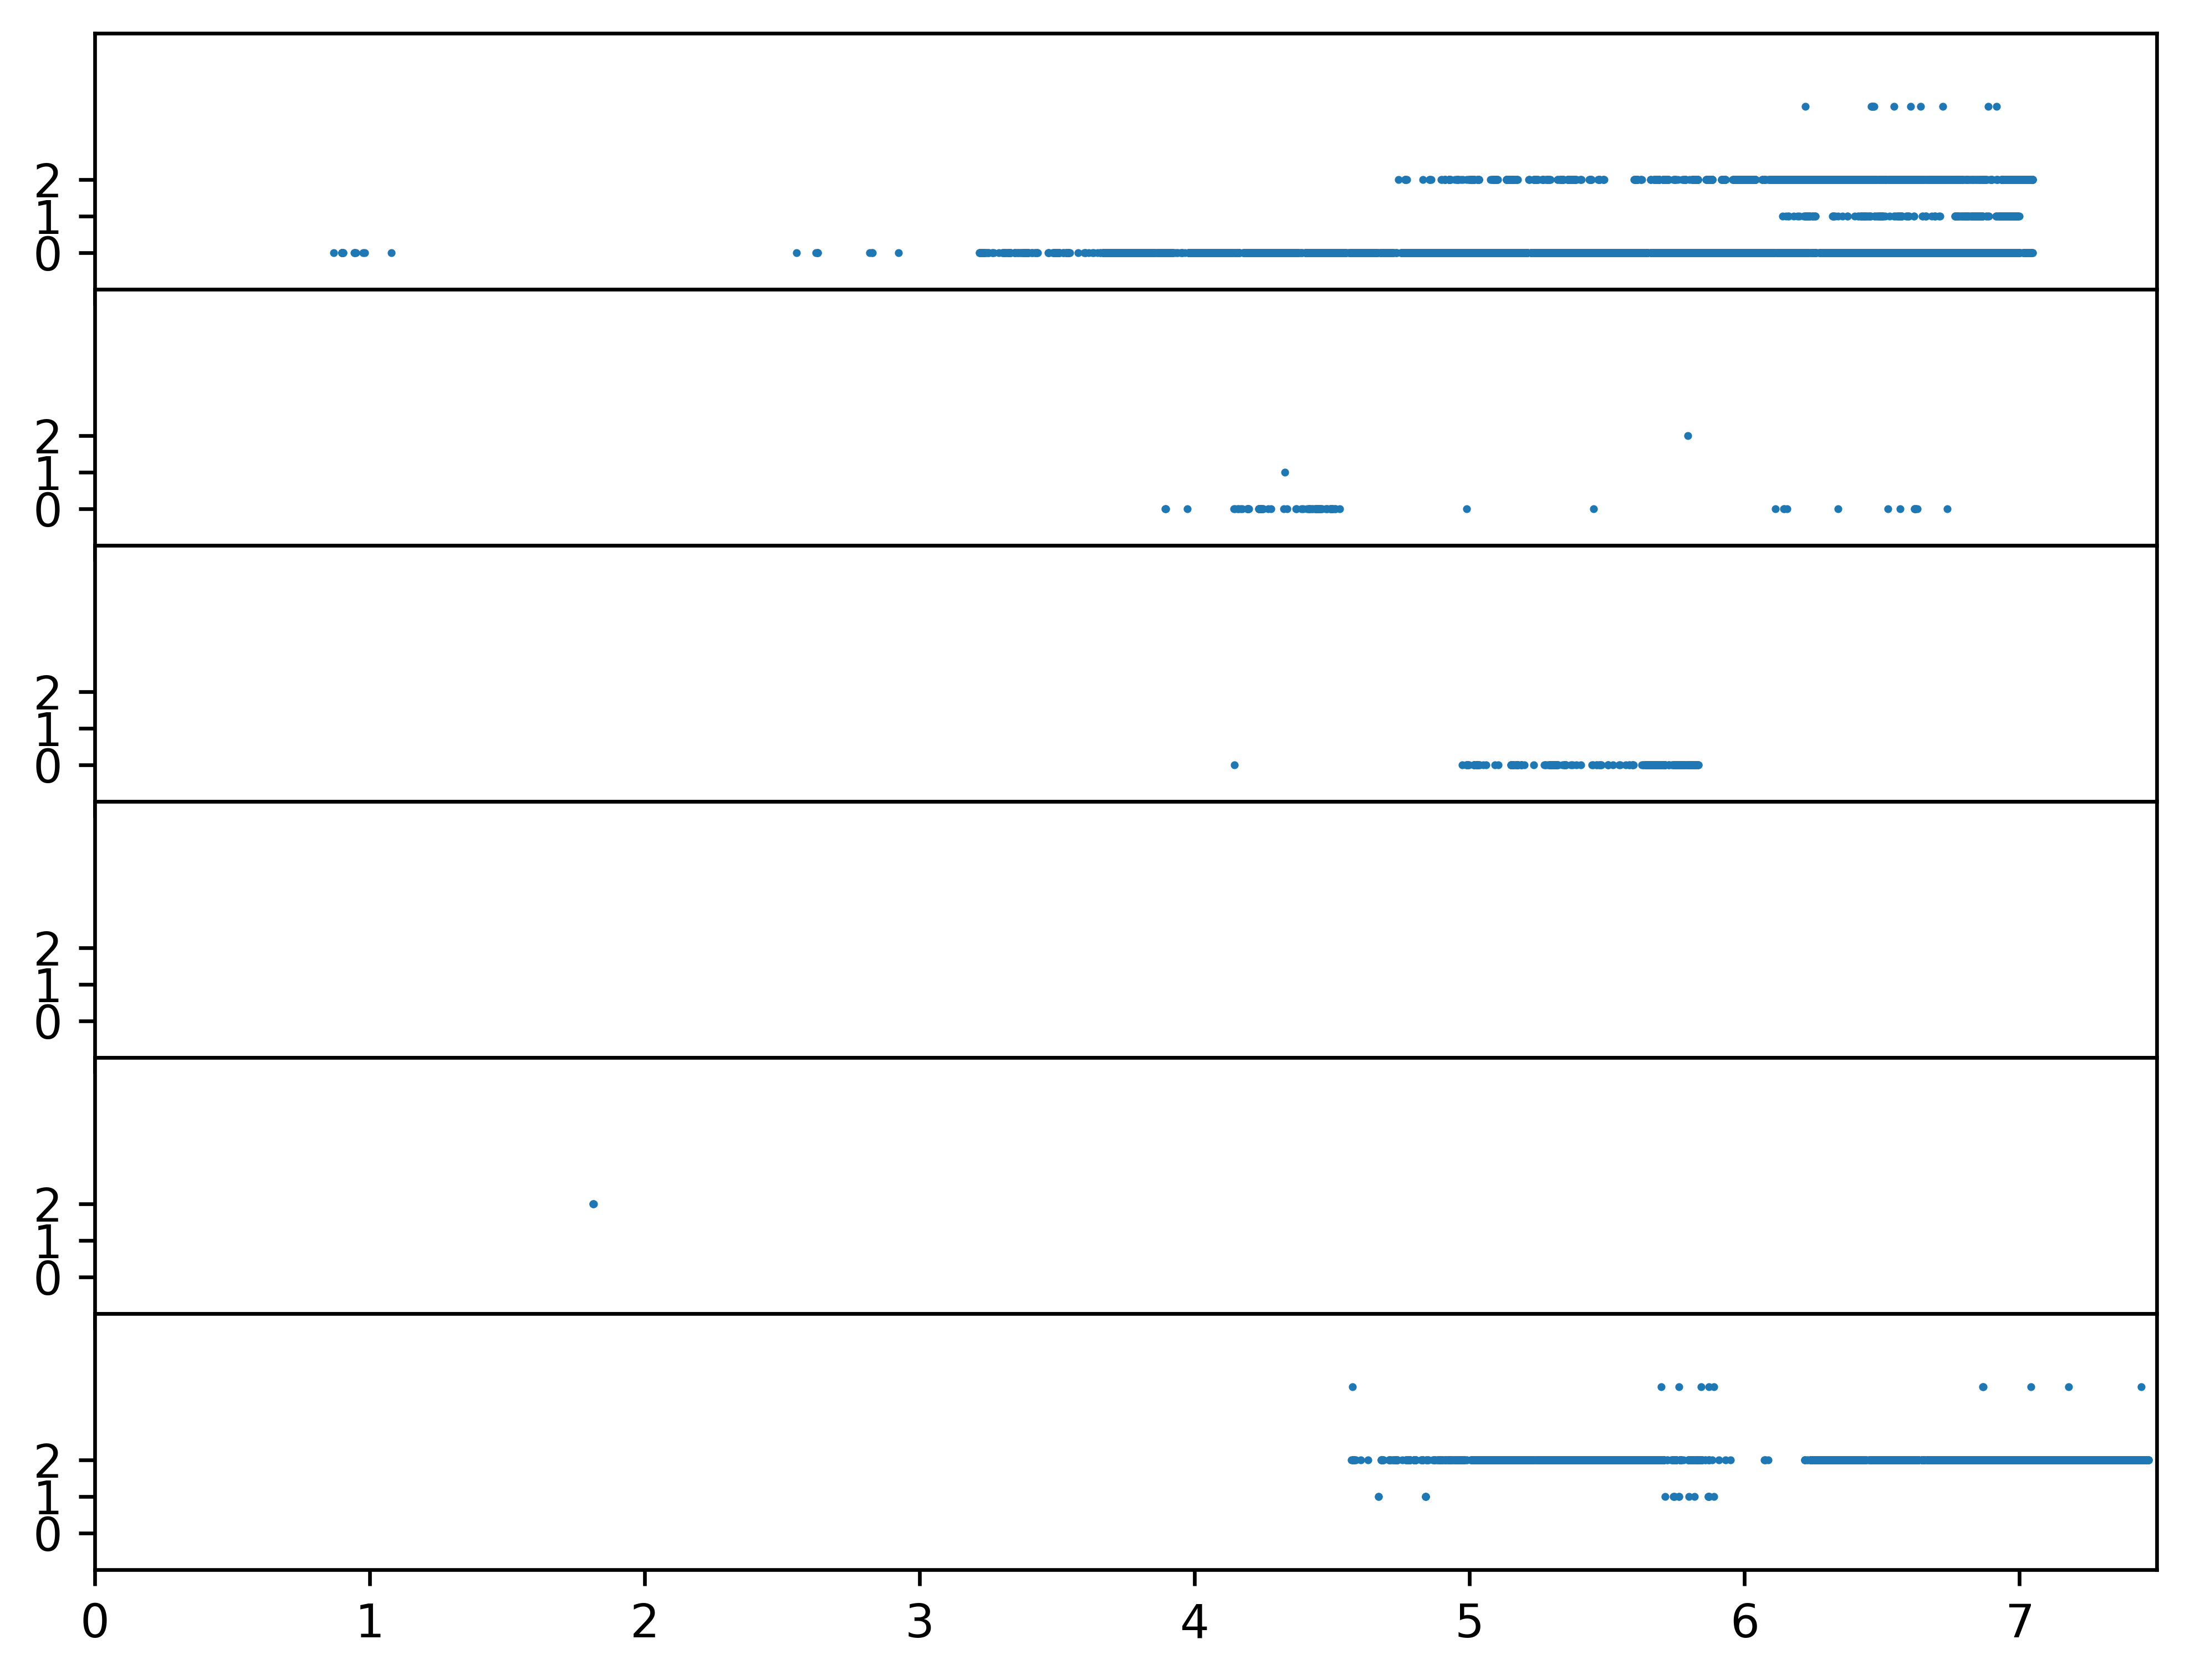

wire forms 0.8653+=0.1289 of the time
ucp1
0
{1: 10}
0
{1: 8}
0
{1: 2}
0
{1: 1425}
0
{1: 42}
0
{1: 7}
path 0: 0.0
path 1: 1.0
path 2: 0.0
path 4: 0.0


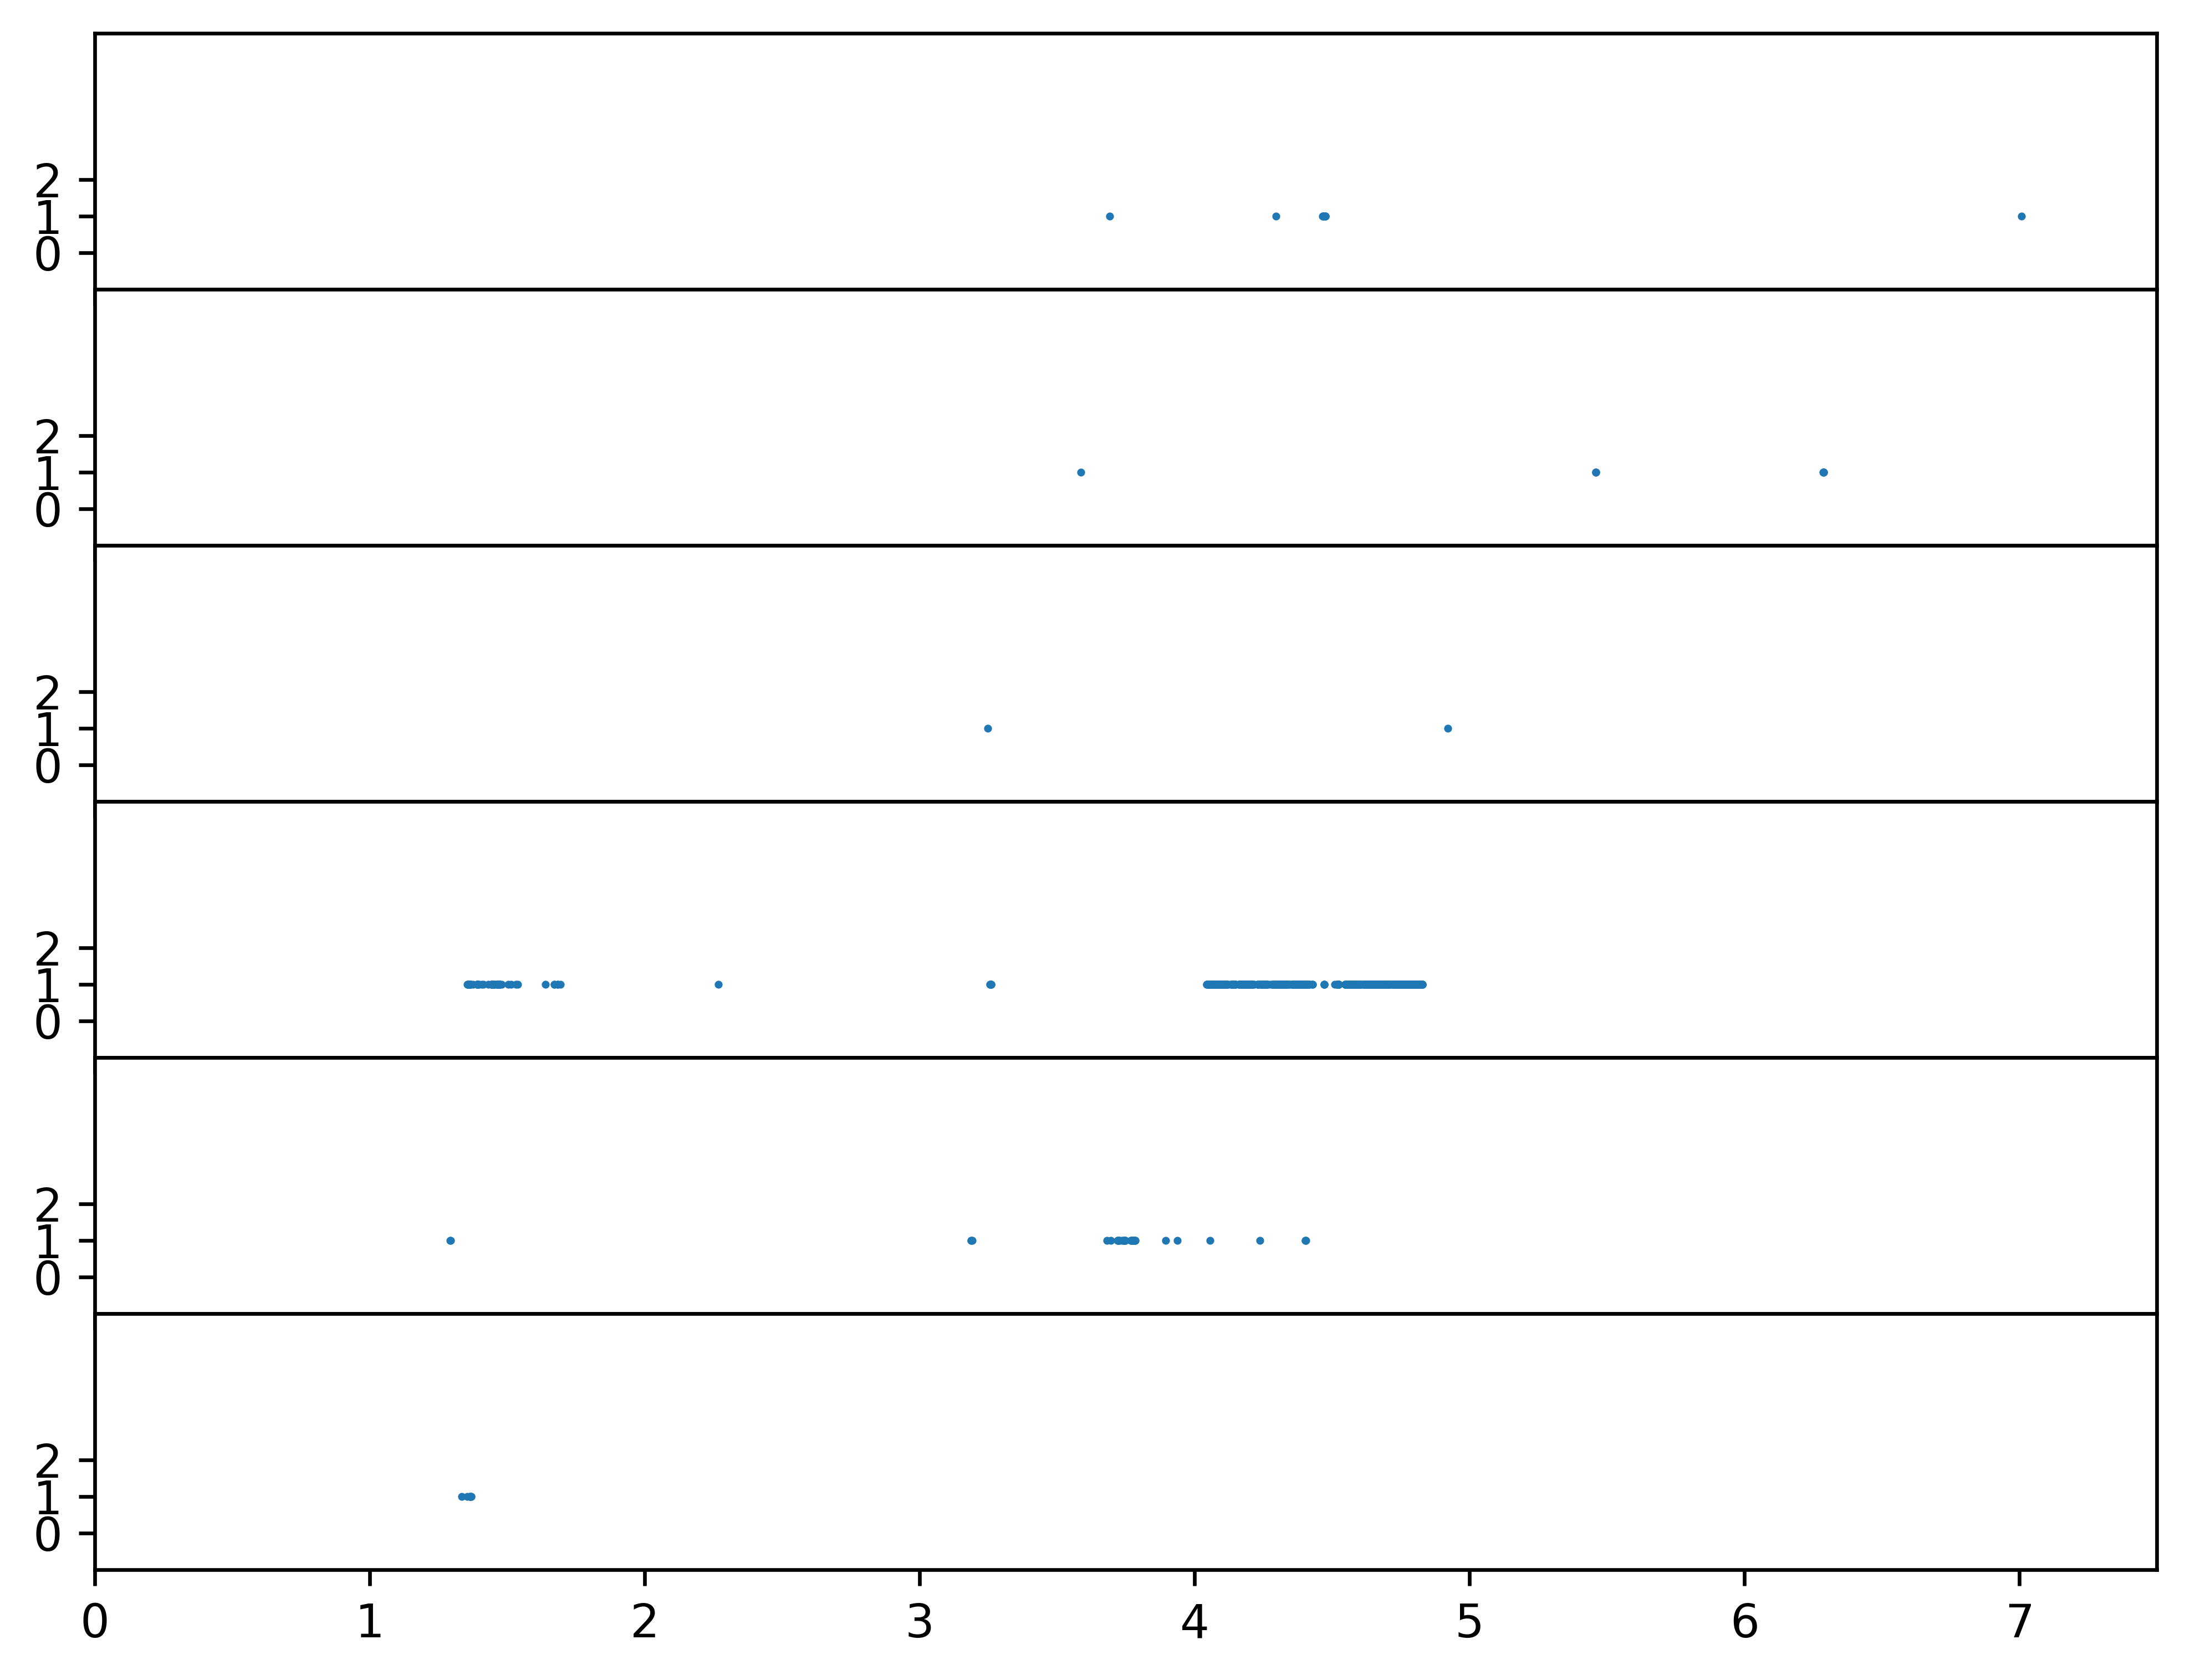

wire forms 0.0035+=0.0019 of the time


In [ ]:
window = 500
threshold = 0.33
colors = ["cyan", "orange", "green", "red", "purple", "grey"]

freqplot = False
multiplot = True

def compile_wire_data():

    #inputpath = "/media/X01Raid01/Data_Backup/home/jborowsky/long-sims/long-aac1-ucp1-processing/water_wires"
    inputpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/water_wires_2"

    servers = ["wynton", "degrabo"]
    proteins = ["aac1", "ucp1"]

    #loop over servers, proteins, and parallel runs
    for protein in proteins:
        print(protein)
        wire_fractions = []
        legend = []
        ci = 0

        path_counts = {0:0, 1:0, 2:0, 4:0}

        if not multiplot:
            plt.figure(figsize = (15,6), dpi=600)

        else:
            fig = plt.figure(figsize = (8,6), dpi=600)
            gs = fig.add_gridspec(6, hspace=0) #-0.2 works otherwise
            axs = gs.subplots(sharex=True, sharey=True)

        # fig.suptitle('Sharing both axes')
        # axs[0].plot(x, y ** 2)
        # axs[1].plot(x, 0.3 * y, 'o')
        # axs[2].plot(x, y, '+')

        #pml_out_lines = ["delete all\n", f"load /home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/long-aac1-ucp1-processing/wynton/{protein}/input/seg_0035.gro\n"] 
        for server in servers:
            #toppath = f"{inputpath}/{server}/{protein}/input/seg_0035.gro"
            for run in range(1,5):
                if server == "degrabo" and run > 2:
                    continue

                #step is in microseconds
                if server == "wynton" and (run == 3 or run == 4):
                    step = 1/10000
                else:
                    step = 1/5000

                gaps = []
                paths = []
 
                for seg in range(1, 20):
                    segstr = str(seg).zfill(2)
                    fn1 = f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run0{run}-seg{segstr}"
                    
                    if os.path.exists(fn1+"-paths.npy"):
                        paths.append(np.load(fn1+"-paths.npy"))
                        gaps.append(np.load(fn1+"-gaps.npy"))

                gaps = np.concatenate(gaps)
                wire_args = np.argwhere(gaps < threshold)
                paths = np.concatenate(paths)
                bin_dists = np.where(paths < threshold, 1, 0)

                print(min(paths))
                wire_fractions.append(np.mean(bin_dists))

                smoothed_dists = [np.mean(paths[i:i+window]) for i in range(len(paths)-window)]
                smoothed_bin_dists = [np.mean(bin_dists[i:i+window]) for i in range(len(bin_dists)-window)]
                #print(smoothed_bin_dists)
                if freqplot:
                    plt.plot([i*step for i in range(len(smoothed_bin_dists))], smoothed_bin_dists, linewidth = 0.5, color = colors[ci])
                else:
                    if not multiplot:
                        plt.plot([i*step for i in range(len(paths))], paths, linewidth = 0.5, color = colors[ci])
                    elif multiplot:
                        steps_all = np.array([i*step for i in range(len(paths))])

                        steps_masked = steps_all[wire_args]

                        unique, counts = np.unique(paths[wire_args], return_counts=True)
                        ucd = dict(zip(unique, counts))
                        for k in ucd.keys():
                            path_counts[k] += ucd[k]

                        print(ucd)
                        #print()

                        axs[ci].scatter(steps_masked, paths[wire_args], s = 0.5)
                        #axs[ci].axhline(0.33, 0, 8, color="black", zorder = 0)
                        #axs[ci].axhline(0.33, 0, 8, color="black", zorder = 10, alpha = 0.3)
                        axs[ci].set_xlim(0,7.5)
                        axs[ci].set_yticks([0, 1, 2])
                        #if ci != 5:
                        #    axs[ci].tick_params(axis='y', labelleft=False)

                        #axs[ci].set_ylabel("Water wire gap (nm)", labelpad = 15)

                        #     axs[ci].set_yticklabels([])
                        # else:
                        #     axs[ci].set_yticklabels([0.25, 0.5, 0.75, 1])

                        axs[ci].set_ylim(-1,6)
                        #axs[ci].legend([f"{server} run {run}"])
                #plt.plot([i*step for i in range(len(dists)-window)], smoothed_dists, linewidth = 1, color = colors[ci])
                #plt.plot([i*step for i in range(len(dists))], dists, linewidth = 0.5, alpha = 0.2)

                legend.append(f"{server} run {run}")

                ci += 1

        total_entries= np.sum([path_counts[pck] for pck in path_counts.keys()])
        for pck in path_counts.keys():
            print(f"path {pck}: {path_counts[pck]/total_entries}")


        if freqplot:
            plt.xlim(0,7.5)
            plt.ylim(-0.02, 1.02)
            plt.legend(legend)
            plt.show()
        elif not multiplot:
            plt.axhline(0.33, 0, 8, color="black")
            plt.xlim(0,7.5)
            plt.ylim(0.25,1)
            plt.legend(legend)
            plt.show()
        elif multiplot:
            #plt.xlabel("Time (µs)")#, labelpad = 15)
            fig.savefig(f"{inputpath}/water_wire_gap_{protein}.png", bbox_inches='tight', format ='png')
            plt.show()

        #print(wire_fractions)
        print(f"wire forms {np.round(np.mean(wire_fractions), 4)}+={np.round(np.std(wire_fractions), 4)} of the time")


compile_wire_data()

#path 0: TM23; 1: TM45, 2: TM61

In [ ]:
plt.figure(figsize = (15,6), dpi=600)